# Create a SageMaker Pipeline to Build and Train your HuggingFace Model

In this notebook, we are going to build a SageMaker Pipeline that will train (and retrain) a sentiment analysis hugging face model using as a base: distilbert-base-uncased

In [ ]:
from sagemaker.huggingface import HuggingFaceProcessor
from sagemaker.pytorch import PyTorchProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role
import boto3
import sagemaker

In [ ]:
sess = boto3.Session()
sm = sess.client("sagemaker")
role = get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=sess)
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

In [ ]:
s3_input_prefix = 'a2i-output'
s3_output_prefix = 'nlp_summit_workshop_processing_output'

In [ ]:
s3 = boto3.client('s3')
res = s3.put_object(Bucket=bucket, Key=(s3_input_prefix+'/sample.txt'), Body=b'') # This is necessary to create the needed key in S3 where will later on be storing the human annotations

## Make pipeline

In [ ]:
model_package_group_name = f"HuggingFaceSentimentPackageGroupName"

In [ ]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value="ml.m5.xlarge")
training_instance_count = ParameterInteger(name="TrainingInstanceCount", default_value=1)
training_instance_type = ParameterString(name="TrainingInstanceType", default_value='ml.p3.2xlarge')
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value="PendingManualApproval")


In [ ]:
# Below we are defining a rety policy that we will apply for a number of the steps below. 
# This will make our pipeline more resiliant. If you want to know more about this, read the blog https://towardsdatascience.com/i-tried-scaling-sagemaker-pipeline-executions-and-this-happened-31279b92821e

from sagemaker.workflow.retry import (
    StepRetryPolicy,
    StepExceptionTypeEnum,
    SageMakerJobStepRetryPolicy,
    SageMakerJobExceptionTypeEnum
)

# Here we define which exceptions to capture and when to retry the step
step_retry_policy = StepRetryPolicy(
    exception_types=[
        StepExceptionTypeEnum.SERVICE_FAULT,
        StepExceptionTypeEnum.THROTTLING,
    ],
    backoff_rate=2.0, # the multiplier by which the retry interval increases during each attempt
    interval_seconds=30, # the number of seconds before the first retry attempt
    expire_after_mins=240  # keep trying for for 4 hours max
)

job_retry_policy = SageMakerJobStepRetryPolicy(
    exception_types=[SageMakerJobExceptionTypeEnum.RESOURCE_LIMIT],
    failure_reason_types=[
        SageMakerJobExceptionTypeEnum.INTERNAL_ERROR,
        SageMakerJobExceptionTypeEnum.CAPACITY_ERROR,
    ],
    backoff_rate=2.0, # the multiplier by which the retry interval increases during each attempt
    interval_seconds=30, # the number of seconds before the first retry attempt
    expire_after_mins=240  # keep trying for for 4 hours max
)

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.pipeline_context import PipelineSession

pipeline_session = PipelineSession()

hfp = PyTorchProcessor(
    role=role, 
    instance_count=processing_instance_count,
    instance_type=processing_instance_type,
    framework_version='1.8',
    base_job_name='frameworkprocessor-hf',
    sagemaker_session=pipeline_session,
)

processor_args = hfp.run(
                        code='processing-script.py',
                        source_dir='scripts',
                        inputs=[
                            ProcessingInput(
                                input_name='data',
                                source=f's3://{bucket}/{s3_input_prefix}',
                                destination='/opt/ml/processing/input/data/'
                            )
                        ],
                        outputs=[
                            ProcessingOutput(output_name='train', source='/opt/ml/processing/output/train/', destination=f's3://{bucket}/{s3_output_prefix}/train'),
                            ProcessingOutput(output_name='test', source='/opt/ml/processing/output/test/', destination=f's3://{bucket}/{s3_output_prefix}/test'),
                        ]
)

step_process = ProcessingStep(name="PrepareAugmentedData", step_args=processor_args)


In [ ]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased'
                 }

# image_uri="763104351884.dkr.ecr.eu-west-1.amazonaws.com/huggingface-pytorch-training:1.7-transformers4.6-gpu-py36-cu110-ubuntu18.04"
train_image_uri = sagemaker.image_uris.retrieve(framework='huggingface', 
                                              region=region, 
                                              instance_type="ml.p3.2xlarge", # Needed to identify if GPU or CPU container is needed
                                              image_scope="training", 
                                              version="4.6", 
                                              base_framework_version="pytorch1.7"
                                             )

huggingface_estimator = HuggingFace(entry_point='train.py',
                                    source_dir='./scripts',
                                    instance_type=training_instance_type,
                                    instance_count=training_instance_count,
                                    role=role,
                                    transformers_version='4.6',
                                    pytorch_version='1.7',
                                    py_version='py36',
                                    hyperparameters = hyperparameters,
                                    image_uri=train_image_uri,
                                   )


In [ ]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


step_train = TrainingStep(
    name="HuggingFaceModelFineTune",
    estimator=huggingface_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "test": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            content_type="text/csv",
        ),
    },
    retry_policies=[
        step_retry_policy,
        job_retry_policy
    ]
)

In [ ]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.step_collections import RegisterModel


inf_image_uri = sagemaker.image_uris.retrieve(framework='huggingface', 
                                              region=region, 
                                              instance_type="ml.m5.xlarge", # Needed to identify if GPU or CPU container is needed
                                              image_scope="inference", 
                                              version="4.6", 
                                              base_framework_version="pytorch1.7"
                                             )

step_register = RegisterModel(
    name="RegisterModel",
    estimator=huggingface_estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.m5.xlarge", "ml.m5.2xlarge"], # instance types recommended by data scientist to be used for real-time endpoints
    transform_instances=["ml.m5.xlarge", "ml.m5.2xlarge"], # instance types recommended by data scientist to be used for batch transform jobs
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    image_uri=inf_image_uri
)

In [ ]:
from sagemaker.workflow.pipeline import Pipeline


pipeline_name = f"SentimentModelRetrain"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        training_instance_count,
        training_instance_type,
        model_approval_status,
    ],
    steps=[step_process, step_train, step_register],
)

In [ ]:
import json


definition = json.loads(pipeline.definition())
definition

In [ ]:
pipeline.upsert(role_arn=role)
execution = pipeline.start()
execution.describe()

### Wait for the execution to finish, Navigate to Model registry and Approve the latest produce model model


In [ ]:
execution.wait()
execution.list_steps()


<br>

![1-MR-firstview.png](images/1-MR-firstview.png)
<br>

![1-MR-secondview.png](images/1-MR-secondview.png)
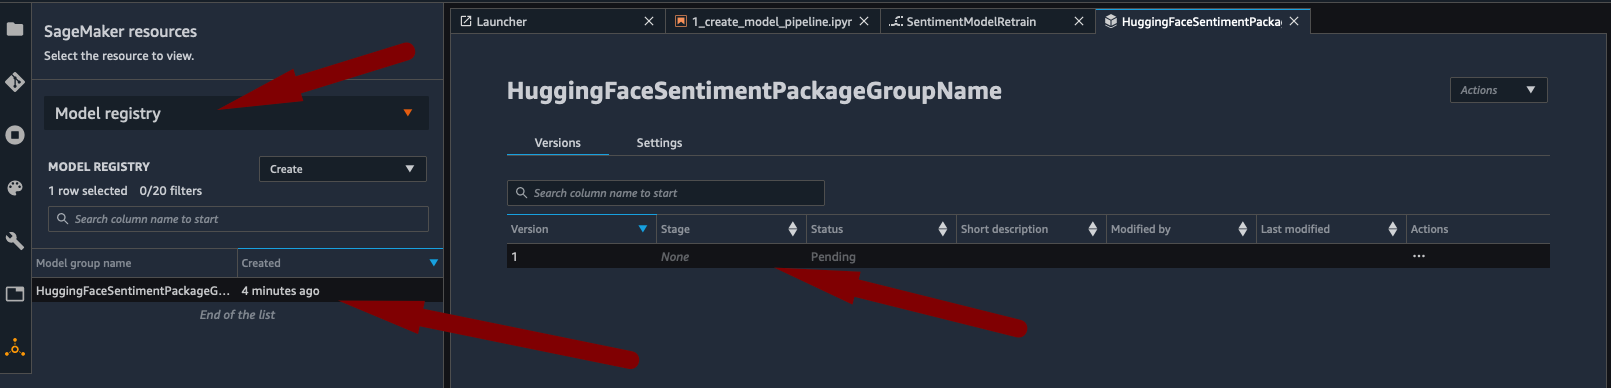
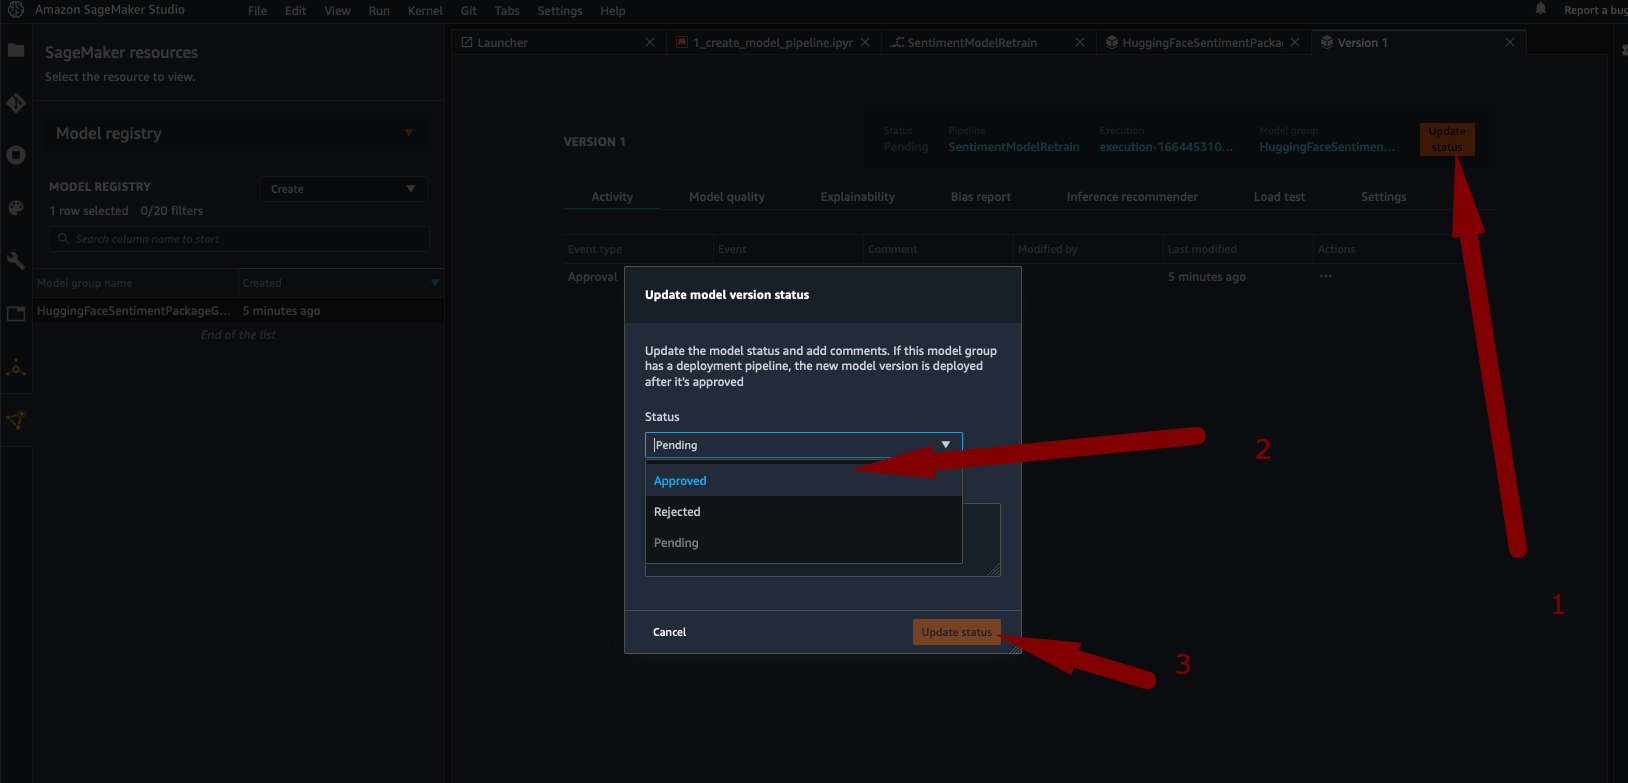